In [1]:
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
#import seaborn as sns
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from IPython.display import clear_output
from scipy.stats import chi2
from scipy.stats import norm
from scipy.stats import gaussian_kde
import scipy.stats as sct
from astropy.coordinates import SkyCoord as scr
from astropy import units as u
from time import sleep

In [2]:
####
#### IMPORTING AND SPLITTING ICDATA $$$


path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
t_eff_path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/uptime"
irf_path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/irfs"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
"IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]
file = filenames[0]
f = open(os.path.join(path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    #print(len(lines) - 1)
    for line in lines[1:]:
        content.append(line.split())
    f.close()
icdata = pd.DataFrame(content, columns=column, dtype=float)#.convert_dtypes(infer_objects=True,convert_integer=True,convert_floating=True)
icdata['log10(E/GeV)'] = [float(i) for i in icdata['log10(E/GeV)']]
icdata['MJD[days]'] = [float(i) for i in icdata['MJD[days]']]

print("read icdata")
f.close()



#Importing UPtime data
file = filenames[0]
f = open(os.path.join(t_eff_path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
uptdata = []
for file in filenames:
    content = []
    f = open(os.path.join(t_eff_path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
    temp = pd.DataFrame(content, columns=column)
    temp['MJD_start[days]'] = [float(i) for i in temp['MJD_start[days]']]
    temp['MJD_stop[days]'] = [float(i) for i in temp['MJD_stop[days]']]
    uptdata.append(temp)
    temp = []
    content = []
    print(file + " read")
f.close()



filenames = ["IC40_effectiveArea.csv", "IC59_effectiveArea.csv","IC79_effectiveArea.csv", "IC86_I_effectiveArea.csv", "IC86_II_effectiveArea.csv"]
file = filenames[0]
f = open(os.path.join(irf_path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
eadata = []
for file in filenames:
    content = []
    f = open(os.path.join(irf_path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
    temp = pd.DataFrame(content, columns=column, dtype=float)
    #temp['MJD_start[days]'] = [float(i) for i in temp['MJD_start[days]']]
    #temp['MJD_stop[days]'] = [float(i) for i in temp['MJD_stop[days]']]
    eadata.append(temp)
    temp = []
    content = []
    print(file + " read")
f.close()

read icdata
IC40_exp.csv read
IC59_exp.csv read
IC79_exp.csv read
IC86_I_exp.csv read
IC86_II_exp.csv read
IC86_III_exp.csv read
IC86_IV_exp.csv read
IC86_V_exp.csv read
IC86_VI_exp.csv read
IC86_VII_exp.csv read
IC40_effectiveArea.csv read
IC59_effectiveArea.csv read
IC79_effectiveArea.csv read
IC86_I_effectiveArea.csv read
IC86_II_effectiveArea.csv read


In [3]:
icdata.dtypes

MJD[days]       float64
log10(E/GeV)    float64
AngErr[deg]     float64
RA[deg]         float64
Dec[deg]        float64
Azimuth[deg]    float64
Zenith[deg]     float64
dtype: object

In [4]:
eadata[0].dtypes

log10(E_nu/GeV)_min    float64
log10(E_nu/GeV)_max    float64
Dec_nu_min[deg]        float64
Dec_nu_max[deg]        float64
A_Eff[cm^2]            float64
dtype: object

In [5]:
icwidths = [int(i) for i in "0 36900 107011 93133 136244 112858 122541 127045 129311 123657 145750".split(' ')]
print(np.sum(icwidths))

1134450


In [7]:
icdata

,MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
0,54562.379113,3.31,0.48,203.024,16.760,218.374,106.712
1,54562.386622,5.17,0.62,75.024,-13.371,349.100,76.646
2,54562.387892,3.92,0.56,97.501,11.290,327.060,101.291
3,54562.392677,5.57,1.13,305.857,-33.932,120.413,56.090
4,54562.404776,5.80,1.11,143.516,-38.279,287.171,51.684
...,...,...,...,...,...,...,...
1134445,58307.961110,5.14,0.20,221.246,-59.959,141.239,29.956
1134446,58307.962666,2.94,1.23,191.547,4.415,171.627,94.312
1134447,58307.963556,2.88,0.30,308.127,42.543,55.437,132.606
1134448,58307.963972,2.98,0.21,332.199,44.720,31.489,134.811


In [8]:
ictimes = [float(i) for i in icdata['MJD[days]']]
icparts = [np.sum(icwidths[:i]) for i in range(1,len(icwidths)+1)]
#icparts.pop(-1)
icparts

[0,
 36900,
 143911,
 237044,
 373288,
 486146,
 608687,
 735732,
 865043,
 988700,
 1134450]

In [9]:
#If icdata[mjddays] > tstop[i], go to next one till < tstop[i] then uptime = icdata[mjddays] - tstart[i]
uptime = []
#for nu_time in ictimes:
def nu_upt(nu):

    '''
    Returns the detector uptime corresponding to a neutrino time
    '''

    ind = -1
    for wall in range(len(icparts) - 1):
        if nu >= icparts[wall] and nu < icparts[wall+1]:
            #break
            for i in range(len(uptdata[wall])):
                if ictimes[nu] <= uptdata[wall]['MJD_stop[days]'].values[i] and ictimes[nu] >= uptdata[wall]['MJD_start[days]'].values[i]:
                #    continue
                #else:
                    #print(i)
                    ind = i
                    break
            break
    #print(nu)
    #clear_output(wait=True)
    sleep(0.0000001)
    return ictimes[nu] - uptdata[wall]['MJD_start[days]'].values[ind]
    

pool = mul.Pool(8, maxtasksperchild=150)
op_async = pool.map_async(nu_upt, range(len(ictimes)))
uptime = op_async.get()
op_async = []
pool= []

In [10]:
uptime[-1]

0.00496436999674188

In [11]:
try:
    uptime.index(None)
except ValueError:
    print("All values are present")   

All values are present


In [13]:
upt_icparts = icparts[:5]
upt_icparts.append(icparts[-1])
len(upt_icparts) - 1 == len(eadata)

True

In [15]:
icdata[0:2]

,MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
0,54562.379113,3.31,0.48,203.024,16.760,218.374,106.712
1,54562.386622,5.17,0.62,75.024,-13.371,349.100,76.646


In [16]:
eadata[0]

,log10(E_nu/GeV)_min,log10(E_nu/GeV)_max,Dec_nu_min[deg],Dec_nu_max[deg],A_Eff[cm^2]
0,2.0,2.2,-90.00,-73.74,0.0
1,2.2,2.4,-90.00,-73.74,0.0
2,2.4,2.6,-90.00,-73.74,0.0
3,2.6,2.8,-90.00,-73.74,0.0
4,2.8,3.0,-90.00,-73.74,0.0
...,...,...,...,...,...
1995,9.0,9.2,73.74,90.00,0.0
1996,9.2,9.4,73.74,90.00,0.0
1997,9.4,9.6,73.74,90.00,0.0
1998,9.6,9.8,73.74,90.00,0.0


In [17]:
log_e = np.arange(2, 10.2, 0.2)
dec_nu = list(set(eadata[0]['Dec_nu_min[deg]'].values).union(set(eadata[0]['Dec_nu_max[deg]'].values)))
dec_nu.sort()
dec_nu = np.array(dec_nu)

In [18]:
log_e[np.argmin(np.abs(log_e - 3.31))]

3.4000000000000012

In [30]:
xaa = [1,2,3,4,5,6,7,7,9,10]

xaa[len(xaa) -1]

10

In [49]:
upt_icparts

[0, 36900, 143911, 237044, 373288, 1134450]

In [110]:
def nu_ea_quick(nu):

    '''
    Returns the detector effective area corresponding to a neutrino
    '''
    
    aeff = -1
    nu_e = icdata['log10(E/GeV)'].values[nu]
    nu_decl = icdata['Dec[deg]'].values[nu]
    for wall in range(len(upt_icparts) - 1):
        if nu >= upt_icparts[wall] and nu < upt_icparts[wall+1]:
            e_ind = 0
            d_ind = 0
            for i in range(len(log_e) - 1):
                if nu_e >= log_e[i] and nu_e < log_e[i+1]:
                    e_ind = i
                    
                
            for i in range(len(dec_nu) - 1):
                if nu_decl >= dec_nu[i] and nu_decl < dec_nu[i+1]:
                    d_ind = i
                    
            #print([np.round(log_e[e_ind], 1), np.round(log_e[e_ind+1], 1)])
            #print([np.round(dec_nu[d_ind], 2), np.round(dec_nu[d_ind+1], 2)])
            #print([icdata['Dec[deg]'].values[nu], icdata['log10(E/GeV)'].values[nu]])
            i = 0

            while i < (len(eadata[wall]) - 1) and eadata[wall]['Dec_nu_min[deg]'].values[i] != np.round(dec_nu[d_ind], 2):
                i += 1
            #rint(i)
            while i < (len(eadata[wall]) - 1) and eadata[wall]['Dec_nu_max[deg]'].values[i] != np.round(dec_nu[d_ind+1], 2):
                i += 1
            #print(i)
            while i < (len(eadata[wall]) - 1) and eadata[wall]['log10(E_nu/GeV)_min'].values[i] != np.round(log_e[e_ind], 1):
                i += 1
            #print(i)
            while i < (len(eadata[wall]) - 1) and eadata[wall]['log10(E_nu/GeV)_max'].values[i] != np.round(log_e[e_ind+1], 1):
                i += 1
            #print(i)
            aeff = eadata[wall]['A_Eff[cm^2]'].values[i]
            return aeff

In [111]:
eadata[0]['Dec_nu_min[deg]'].values

array([-90.  , -90.  , -90.  , ...,  73.74,  73.74,  73.74])

In [112]:
print(nu_ea_quick(0))

2094.33


In [113]:
def nu_ea(nu):

    '''
    Returns the detector effective area corresponding to a neutrino
    '''
    
    aeff = -1
    for wall in range(len(upt_icparts) - 1):
        if nu >= upt_icparts[wall] and nu < upt_icparts[wall+1]:
            for i in range(len(eadata[wall])):
                if icdata['Dec[deg]'].values[nu] >= eadata[wall]['Dec_nu_min[deg]'].values[i] and icdata['Dec[deg]'].values[nu] < eadata[wall]['Dec_nu_max[deg]'].values[i]:
                    if icdata['log10(E/GeV)'].values[nu] <= eadata[wall]['log10(E_nu/GeV)_max'].values[i] and icdata['log10(E/GeV)'].values[nu] >= eadata[wall]['log10(E_nu/GeV)_min'].values[i]:
                        aeff = eadata[wall]['A_Eff[cm^2]'].values[i]
                        #break
                        sleep(0.00001)
                        return aeff


In [114]:

#mul.set_start_method('spawn', force=True)
op_async = []
pool= []
pool = mul.Pool(8, maxtasksperchild=150)
op_async = pool.map_async(nu_ea_quick, range(len(icdata)))
aeff = op_async.get()
op_async = []
pool= []

                      return aeff

#mul.set_start_method('spawn', force=True)
pool = mul.Pool(8, maxtasksperchild=150)
op_async = pool.map_async(nu_ea, range(len(icdata)))
aeff = op_async.get()
op_async = []
pool= []

icdata.insert(0, "Uptime[days]", uptime)
icdata

In [115]:
try:
    print(aeff.count(None))
except ValueError:
    print("All values are present")   

0


In [117]:
#IMPORTING MSPDATA
f = open("/media/darkwake/VIB2/Project-IceCube/allpsr1.68.txt", 'r')
lines = f.readlines()
content=[]
column=lines.pop(0).replace('x', '').replace('#', '').split()
for line in lines[:]:
    content.append(line.split())
    #the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
f.close()
mspdata = pd.DataFrame(content).drop(0, axis=1)#.dropna()#.drop_duplicates()#.drop(range(0,6)).dropna()

line = []
lines = []
mspdata.columns = column
column = []
content=[]
#mspdata = mspdata.sort_values('DECJD')
mspdata.dropna(inplace=True)
#mspdata = mspdata.reset_index()
#mspdata = mspdata.drop("index", axis=1)

In [118]:
mspdata

,NAME,RAJD,DECJD
0,J0002+6216,0.74238,62.26928
1,J0006+1834,1.52,18.5831
2,J0007+7303,1.7571,73.0521
3,J0011+08,2.9,8.17
4,B0011+47,3.57396,47.77594
...,...,...,...
3336,J2351+8533,357.764,85.55573
3337,J2352+65,358,65
3338,J2354-22,358.60833,-22.86472
3339,B2351+61,358.5199292,61.9296792


In [119]:
msra = np.array([float(i) for i in mspdata['RAJD'].values])
msdec = np.array([float(i) for i in mspdata['DECJD'].values])
icra = np.array([float(i) for i in icdata['RA[deg]']])
icdec = np.array([float(i) for i in icdata['Dec[deg]']])
icang = np.array([float(i) for i in icdata['AngErr[deg]']])
global p, lg
p = len(msra)
lg = len(icra) // p + 1
#cut = 20
#cone = 3
#psrno = 0

In [120]:
[min(msdec), max(msdec)]

[-83.298894, 86.720335]

In [121]:
icra[[0, 6, 8] ]

array([203.024, 147.017, 236.214])

In [194]:
def hvovec(lon1=0.0, lat1=0.0, lon2=0.0, lat2=0.0, rad=False):

    '''
    Parameters
    ----------
    lon1 : float
        Longitude of first point.
    lat1 : float
        Latitude of first point.


    lon2 : float
        Longitude of second point.
    lat2 : float
        Latitude of second point.

    rad : Boolean, optional
        (default) False -> Angle is returned in Degrees
        True -> Angle is returned in radians
    

    Returns
    -------
    float
        Returns the haversine angle between two vectors given their latitude and longitude
    

    Warning
    -------
        This function assumes the input to be in degrees and of equal length\n
        or one of the input pairs to be a single value and the other pair to be an array
    '''

    #Convert decimal degrees to Radians:
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    #dlat = np.subtract(lat2, lat1)

    a = np.add(np.multiply(np.sin(lat1), np.sin(lat2)), np.multiply(np.multiply(np.cos(lat1), np.cos(lat2)), np.cos(dlon)))

    if rad == True:
        return np.arccos(a)
    else:
        return np.abs(np.rad2deg(np.arccos(a)))


def angdecfinder(psrno, declcut):

    '''

    Parameters
    ----------
    psrno : int
        Pulsar number from the ATNF catalogue.
    
    declcut : float
        Declination cut-off in degrees.



    Returns
    -------
    float
    Returns the absolute difference between the declinations of pulsar {psrno}\n
    and each of the neutrinos within the specified declcut
    '''

    #aang = hvovec(msra[psrno], msdec[psrno], icra, icdec)
    decdf = list(np.abs(np.subtract(icdec, msdec[psrno])))
    nuind = []
    for i in range(0, len(decdf)):
        if decdf[i] < declcut:
            nuind.append(i)
            #decdf.pop(i)
            #aang[i] = -1
    fdecdf = list(np.abs(np.subtract(icdec[nuind], msdec[psrno])))
    return [nuind, decdf]

def S_ij(psrno, nuind): 

    f'''
    Returns the signal PDF for the {psrno}th pulsar 
    and the all neutrinos within the specified declcut as given in {nuind}
    '''

    ang2 = hvovec(msra[psrno], msdec[psrno], icra[nuind], icdec[nuind], rad=True) ** 2
    sg = np.deg2rad(icang[nuind]) ** 2
    return np.exp(-1 * ang2 / (2 * sg)) / (2 * np.pi * sg)


def S_i(psrno, nuind, weights):

        '''
        Parameters
        ----------
        psrno : int
            Pulsar number from the ATNF catalogue.
        nuind : list
            List of indices of neutrinos within the specified declination cut-off.
        weights : list
            List of weights of each neutrino.

        Returns
        -------
        Returns the signal PDF for the {psrno}th pulsar 
        '''


        sij = S_ij(psrno, nuind)
        return np.sum(np.multiply(sij, weights)) / np.sum(weights)

def Bi(psrno, cone):

    '''
    Parameters
    ----------
    psrno : int
        Pulsar number from the ATNF catalogue.
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {psrno}th pulsar 
    '''

    binwidth = (np.sin(np.deg2rad(msdec[psrno] + cone)) - np.sin(np.deg2rad(msdec[psrno] - cone)))*2*np.pi

    return



def bgs(psrno, cone, twopi = False):

    '''
    Returns the background PDF for a given pulsar {psrno} within\n
    a cone of {cone} degrees for SINGLE STACKED ANALYSIS
    '''

    if twopi == True:
        s_ang = (np.sin(np.deg2rad(msdec[psrno] + cone)) - np.sin(np.deg2rad(msdec[psrno] - cone)))*(2 * np.pi)
        return 1/s_ang
    else:
        s_ang = (np.sin(np.deg2rad(msdec[psrno] + cone)) - np.sin(np.deg2rad(msdec[psrno] - cone)))
        return 1/s_ang

def Pr(x, Ns, S, B):

    '''
    Parameters
    ----------
    x : int
        Assumed no.of associated events

    Ns : int
        No.of neutrinos used for analysis

    S : float
        Signal PDF
    B : float
        Background PDF
    
    Returns
    -------
    float 
        Returns the probability of the selected set of neutrinos being associated\n
        with a given pulsar with {Ns} neutrinos, {S} signal and {B} background PDF and {x} assumed associated events
    '''

    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))


def TS(i, x, S, B, Ns):

    '''Returns the Test Stastic value fot {i}^th grb
    at $n_s$ = {x} for its parameters S, B, Ns    '''
    
    return 2*np.sum(np.log(Pr(x,  Ns, S, B)/B))


def ns_for_TSmax(i, S, B, Ns):

    '''
    Returns the value of $n_s$ for which
    the TS is maximum for {i}^th grb
    '''

    #returns the TSmax for i^th GRB
    nll = lambda x: -TS(i,x, S, B, Ns)
    soln = minimize(nll, 6 ,bounds=((0,None),))
    ns = float(soln.x)
    return ns


In [147]:
def singpsr(psrno):
    cut = 5
    cone = 5
    nuind, decdf = angdecfinder(psrno, cut)
    S = S_ij(psrno, nuind)
    B = bgs(psrno, cone, True)
    Ns = len(nuind)
    maxns = ns_for_TSmax(psrno, S, B, Ns)
    return [maxns, np.sqrt(TS(psrno, maxns, S, B, Ns))]

tsmax = []
errpsr = []
pool = mul.Pool(8, maxtasksperchild=800)
op_async = pool.map_async(singpsr, range(p))
tsmax = op_async.get()
op_async = []
pool = []
'''
for i in range(p):
    #try:
    tsmax.append(singpsr2(i))
    #except TypeError:
     #   errpsr.append(i)'''
maxns = []
sqrtts = []
for i in tsmax:
    maxns.append(i[0])
    sqrtts.append(i[1])



sqrtt = np.sqrt(sqrtts)

np.argmax(sqrtt)

In [124]:
psrno = 0
cut = 5
cone = 5
nuind, decdf = angdecfinder(psrno, cut)
S = S_ij(psrno, nuind)
B = bgs(psrno, cone, True)
Ns = len(nuind)
maxns = ns_for_TSmax(psrno, S, B, Ns)

In [125]:
len(S)

38525

In [126]:
singpsr(971)

[0.0, 0.0]

38855


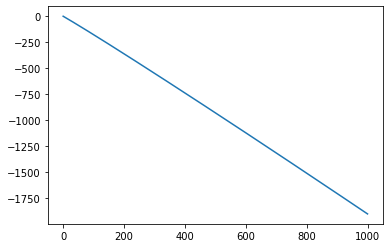

[0.0, 0.0]


In [127]:
def plotpsr(psrno):
    cut = 5
    cone = 5
    nuind, decdf = angdecfinder(psrno, cut)
    S = S_ij(psrno, nuind)
    B = bgs(psrno, cone)
    Ns = len(nuind)
    tns=[TS(psrno, i, S, B, Ns) for i in range(0, 1000)]
    print(Ns)
    plt.plot(range(0, 1000), tns)
    plt.show()
    print([ns_for_TSmax(psrno, S, B, Ns), TS(psrno, ns_for_TSmax(psrno, S, B, Ns), S, B, Ns)])
plotpsr(971)

In [128]:
def psrcustom(arr):
    cut = 5
    cone = 5
    for psrno in arr:
        nearcrd=[]
        for i in range(len(icdec)):
            if abs(icdec[i] - msdec[psrno]) <= cut:
                nearcrd.append([icra[i], icdec[i], icang[i]])
        print([psrno, msra[psrno], msdec[psrno]])
        np.savetxt(f"outputs/ndecnear{psrno}.txt", nearcrd)
        print("len(nearcrd) = ", len(nearcrd))

psrcustom([971])

[971, 228.43658, -59.77553]
len(nearcrd) =  38855


## STACKING ANALYSIS

In [202]:
weights = [aeff[i] * uptime[i] * icdata['log10(E/GeV)'][i]*0.2  for i in range(len(aeff))]

In [203]:
def angfinder(b, cut):
    ang = []
    
    for a in range(lg):
        
        if a != lg - 1:
        #try:
            ilo = icra[a*p:a*p + p]
            ila = icdec[a*p:a*p + p]
            lo = msra[b] * np.ones(p)
            la = msdec[b] * np.ones(p)
            temp = np.abs(hvovec(ilo, ila, lo, la, rad=True))
            ntemp = len(temp)
            for tt in range(len(temp)):
                if temp[tt] > cut:
                    temp[tt] = -1
            ang.extend(temp)
        else:
        #except:
            ilo = icra[a*p:]
            ila = icdec[a*p:]
            ext = len(ilo)
            lo = msra[b] * np.ones(ext)
            la = msdec[b] * np.ones(ext)
            temp = np.abs(hvovec(ilo, ila, lo, la, rad=True))
            #ang.extend(hvovec(ilo, ila, lo, la))
            for tt in range(len(temp)):
                if temp[tt] > cut:
                    temp[tt] = -1
            ang.extend(temp)
        
    return [ang, nuind]
'''
def S_i(psrno, aang, cut, weights): 

    '''
    #Returns the signal PDF for the {psrno}th pulsar 
    #and the all neutrinos within the specified declcut as given in {nuind}
'''
    signal = 0
    for j in range(len(icdata)):
        if aang[j] <= cut:
            ang2 = aang[j] ** 2
            sg = np.deg2rad(icang[j]) ** 2
            signal += weights[j] * np.exp(-1 * ang2 / (2 * sg)) / (2 * np.pi * sg)
        
        return signal/np.sum(weights)


'''

def S_i(psrno, nuind, weights):

        '''
        Parameters
        ----------
        psrno : int
            Pulsar number from the ATNF catalogue.
        nuind : list
            List of indices of neutrinos within the specified declination cut-off.
        weights : list
            List of weights of each neutrino.

        Returns
        -------
        Returns the signal PDF for the {psrno}th pulsar 
        '''


        sij = S_ij(psrno, nuind)
        wts = weights[nuind]
        return np.sum(np.multiply(sij, wts)) / np.sum(wts)



def Ns2(psrno, cut):
    count = 0
    for i in range(len(icdec)):
        if abs(icdec[i] - msdec[psrno]) < cut:
            count+=1
    return count


def Bi(psrno, cone):

    '''
    Parameters
    ----------
    psrno : int
        Pulsar number from the ATNF catalogue.
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {psrno}th pulsar 
    '''
    count = 0
    for i in range(len(icdec)):
        if abs(icdec[i] - msdec[psrno]) < cone:
            count+=1
    binwidth = (np.sin(np.deg2rad(msdec[psrno] + cone)) - np.sin(np.deg2rad(msdec[psrno] - cone)))*2*np.pi

    return count / (binwidth*len(icdata))


def TS(i, x, S, B, Ns):

    '''Returns the Test Stastic value fot {i}^th grb
    at $n_s$ = {x} for its parameters S, B, Ns    '''
    
    return 2*np.sum(np.log(Pr(x,  Ns, S, B)/B))


def ns_for_TSmax(i, S, B, Ns):

    '''
    Returns the value of $n_s$ for which
    the TS is maximum for {i}^th grb
    '''

    #returns the TSmax for i^th GRB
    nll = lambda x: -TS(i,x, S, B, Ns)
    soln = minimize(nll, 3 ,bounds=((0,None),))
    ns = float(soln.x)
    return ns

In [204]:
len(weights)

1134450

In [205]:
weights = np.array(weights)
def singpsr_stacked(psrno):
    cut = 5
    cone = 5
    nuind, decdf = angdecfinder(psrno, cut)
    S = S_i(psrno, nuind, weights)
    B = bgs(psrno, cone)
    Ns = len(nuind)
    maxns = ns_for_TSmax(psrno, S, B, Ns)
    sqrtts = np.sqrt(TS(psrno, np.round(maxns, 4), S, B, Ns))
    return [maxns, sqrtts]

In [206]:
aa, b = singpsr_stacked(1)

/tmp/ipykernel_1062504/2847988121.py:10: RuntimeWarning: invalid value encountered in sqrt
  sqrtts = np.sqrt(TS(psrno, np.round(maxns, 4), S, B, Ns))


In [207]:
aa

2.9999874320381155

In [183]:
tsmax = []
pool = mul.Pool(8, maxtasksperchild=800)
op_async = pool.map_async(singpsr_stacked, range(p))
tsmax = op_async.get()
op_async = []
pool = []
maxns = []
maxts = []
for i in tsmax:
    maxns.append(i[0])
    maxts.append(i[1])

38525


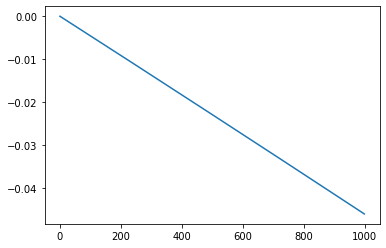

[2.999954522163817, -0.00013641163765055065, 0.0]


In [187]:
def plotpsr_st(psrno):
    cut = 5
    cone = 5
    nuind, decdf = angdecfinder(psrno, cut)
    S = S_i(psrno, nuind, weights)
    B = bgs(psrno, cone)
    Ns = len(nuind)
    tns=[TS(psrno, i, S, B, Ns) for i in range(0, 1000)]
    print(Ns)
    plt.plot(range(0, 1000), tns)
    plt.show()
    print([ns_for_TSmax(psrno, S, B, Ns), TS(psrno, ns_for_TSmax(psrno, S, B, Ns), S, B, Ns), TS(psrno, 0, S, B, Ns)])
plotpsr_st(0)

In [185]:
binnedsts, wsts = np.histogram(maxts, 10)

ne01 = 3
amp  = p/3.0#np.sum(binnedsts)/ne01
#binnedsts = binnedsts/amp
yerr = np.sqrt(binnedsts)
b2 = binnedsts[(binnedsts>10)]
yerr2 = yerr[(binnedsts>10)]
x=0.5*(wsts[1:]+ wsts[:-1])
x2 = x[(binnedsts>10)]
xerr=x[0]-wsts[0]

In [150]:
yerr

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       57.80138407,  0.        ,  0.        ,  0.        ,  0.        ])

In [151]:
wsts

array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5])

In [152]:
#gaussian = lambda x, mean, var:  amp*norm.pdf(x, mean, var)
def gaussian(x,mean,sd):
#    mean=0.114
    A=p/3.0
    return A*np.exp(-(x - mean) ** 2.0 / sd ** 2.0)
loggaussian = lambda x, mean, var:  np.log(gaussian(x, mean, var))
gparam, gerr = curve_fit(gaussian, x2, b2,  p0=[0.1, 1.0],sigma=yerr2, absolute_sigma=True, maxfev = 10000, method='dogbox')
gx = np.linspace(0, wsts[-1], 100)

In [153]:
gparam

array([0.05001221, 1.0033327 ])

In [154]:
max(maxts)

0.0

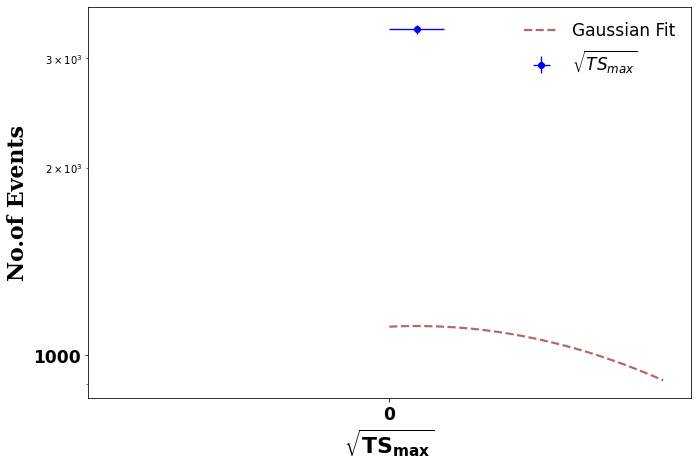

In [155]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.figure(figsize=(10.8,7.2))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize=17, fontweight='bold')
plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize=17, fontweight='bold')

plt.errorbar(x, binnedsts, xerr=xerr,yerr=yerr,  aa = True, barsabove = True, fmt='ob',ecolor='blue', elinewidth=1.35, label='$\sqrt{TS_{max}}$')
plt.plot(gx,gaussian(gx, gparam[0], gparam[1]),'--', alpha=0.6, label=f'Gaussian Fit', color='darkred', lw=2.2)

plt.xlabel("$\mathbf{\sqrt{TS_{max}}}$", fontweight='bold', fontdict=font)
plt.ylabel("No.of Events", fontweight='bold', fontdict=font)
#plt.grid(True, which='major')
legend =plt.legend(prop={'size':17}, framealpha=0)
legend.get_frame().set_facecolor('none')
plt.savefig("outputs/sqrt(TSmax)stacked.pdf")
plt.show()